In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import joblib

In [1]:
df = pd.read_csv('/kaggle/input/pattern/data_labeled_filtered.csv')

# 250 per label → df_small
df_small = (
    df
    .groupby('label', group_keys=False)
    .sample(n=250, random_state=42)
    .reset_index(drop=True)
)

print(df_small['label'].value_counts())


NameError: name 'pd' is not defined

In [ ]:
def preprocess(path, sr=16000):
    # load mono
    y, _ = librosa.load(path, sr=sr, mono=True)
    # trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=20)
    # volume normalize
    y = librosa.util.normalize(y)
    return y

def extract_features(y, sr=16000, n_mfcc=13):
    # MFCC + statistics
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_var  = mfcc.var(axis=1)
    # delta MFCC
    delta_mean = librosa.feature.delta(mfcc).mean(axis=1)
    # spectral centroid & zero crossing rate
    cent_mean = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    zcr_mean  = librosa.feature.zero_crossing_rate(y).mean()
    # combine into one feature vector
    return np.hstack([mfcc_mean, mfcc_var, delta_mean, cent_mean, zcr_mean])


In [ ]:
features = []
labels   = []

for _, row in df_small.iterrows():
    audio_path = os.path.join('/kaggle/input/pattern/all_audio_files', row['path'])
    y = preprocess(audio_path)
    feat = extract_features(y)
    features.append(feat)
    labels.append(row['label'])

X = np.vstack(features)
y = np.array(labels)

print("X shape:", X.shape)   # should be (1000, feature_dim)
print("y distribution:", pd.Series(y).value_counts())


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)


In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf',     RandomForestClassifier(random_state=0))
])

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth':    [None, 10]
}

grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV score:  ", grid.best_score_)


In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
# core
import os
import numpy as np
import pandas as pd

# audio
import librosa

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for saving model
import joblib


In [ ]:
# 2.1 Load full CSV
df = pd.read_csv('/kaggle/input/pattern/data_labeled_filtered.csv')

# df4 = df[df['label'].isin([0,1,2,3])].copy()

# 2.3 Balance: sample N per class (e.g. 500 each)
N = 2500
df_bal = (
    df
    .groupby('age', group_keys=False)
    .sample(n=N, random_state=42)
    .reset_index(drop=True)
)

print(df_bal['age'].value_counts())

In [ ]:
import scipy.signal

def compute_formants(y, sr, n_formants=3, order=16):
    # Estimate LPC and find roots → formant frequencies
    a = librosa.lpc(y, order=order)
    roots = np.roots(a)
    roots = roots[np.imag(roots) >= 0]
    angs = np.angle(roots)
    freqs = angs * (sr / (2 * np.pi))
    freqs = np.sort(freqs)
    return freqs[:n_formants]

def extract_gender_feats(path, sr=16000):
    y, _ = librosa.load(path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=20)
    y = librosa.util.normalize(y)

    feats = []
    # 1) F0 via pyin
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0_clean = f0[~np.isnan(f0)]
    if len(f0_clean) > 0:
        feats += [f0_clean.mean(), f0_clean.std()]
    else:
        feats += [0.0, 0.0]
    # 2) Formants F1–F3
    formants = compute_formants(y, sr)
    feats += list(formants)
    # 3) MFCC + Δ
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    feats += list(mfcc.mean(axis=1))
    feats += list(librosa.feature.delta(mfcc).mean(axis=1))
    # 4) Spectral contrast
    sc = librosa.feature.spectral_contrast(y=y, sr=sr)
    feats += list(sc.mean(axis=1))
    # 5) Chroma
    ch = librosa.feature.chroma_stft(y=y, sr=sr)
    feats += list(ch.mean(axis=1))

    return np.array(feats)


In [ ]:
from tqdm.auto import tqdm
features = []
labels   = []

audio_root = '/kaggle/input/pattern/all_audio_files'

for _, row in tqdm(df_bal.iterrows(), 
                   total=len(df_bal), 
                   desc="Extracting features"):
    path = os.path.join(audio_root, row['path'])
    feats = extract_gender_feats(path)
    features.append(feats)
    labels.append(row['age'])

X = np.vstack(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels distribution:", pd.Series(y).value_counts())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

In [ ]:
pipelines = {
    'rf': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=0))]),
    'svm': Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True, random_state=0))]),
}

param_grids = {
    'rf': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 15]
    },
    'svm': {
        'clf__C': [1, 10],
        'clf__gamma': ['scale', 0.01]
    }
}

best_models = {}
for name in pipelines:
    print(f"\n=== Tuning {name} ===")
    grid = GridSearchCV(pipelines[name], param_grids[name], cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("CV score:  ", grid.best_score_)
    best_models[name] = grid.best_estimator_


In [ ]:
for name, model in best_models.items():
    print(f"\n--- Results for {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0','1'], yticklabels=['0','1'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.semi_supervised import LabelPropagation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [3]:
# 1. Load and filter for your two age-groups:
df = pd.read_csv('/kaggle/input/pattern/data_labeled_filtered.csv')
# say your two groups are coded 0 and 1:
df2 = df[df['age'].isin([0, 1])].reset_index(drop=True)

In [5]:
# 2. Balance them (N samples per class):
N = 5000
df_bal = ( df2
           .groupby('age', group_keys=False)
           .sample(n=N, random_state=42)
           .reset_index(drop=True) )

print("Balanced counts:", df_bal['age'].value_counts())

Balanced counts: age
0    5000
1    5000
Name: count, dtype: int64


In [7]:
# 3. Feature‐extraction function (46 features total):
def extract_age_feats(path, sr=16000):
    y, _ = librosa.load(path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=20)
    y = librosa.util.normalize(y)

    feats = []
    # — MFCCs (40 coefficients: only the means)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    feats += list(mfcc.mean(axis=1))

    # — Spectral Centroid
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    feats.append(cent.mean())

    # — Spectral Bandwidth
    bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    feats.append(bw.mean())

    # — Spectral Contrast (collapsed to one scalar)
    sc = librosa.feature.spectral_contrast(y=y, sr=sr)
    feats.append(sc.mean())

    # — Spectral Flatness
    flat = librosa.feature.spectral_flatness(y=y)
    feats.append(flat.mean())

    # — Spectral Roll‑off at 85%
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    feats.append(roll.mean())

    # — Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=y)
    feats.append(zcr.mean())

    return np.array(feats)


In [8]:
# 4. Loop over your balanced DataFrame:
features, labels = [], []
root = '/kaggle/input/pattern/all_audio_files'

for _, row in tqdm(df_bal.iterrows(), total=len(df_bal), desc="Feat extr"):
    p = os.path.join(root, row['path'])
    features.append(extract_age_feats(p))
    labels.append(row['age'])

X = np.vstack(features)
y = np.array(labels)
print("X shape:", X.shape)   # should be (2*N, 46)

Feat extr:   0%|          | 0/10000 [00:00<?, ?it/s]

X shape: (10000, 46)


In [9]:
# 5. Train/Test split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)


In [19]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pipelines = {
    'lp': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000))
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'rf': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=0))
    ]),
    'svm': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, random_state=0))
    ]),
}


In [21]:
# 7. (Optional) Hyper­parameter grids for KNN:
param_grids = {
    'knn': {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    },
    'rf': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 15]
    },
    'svm': {
        'clf__C': [1, 10],
        'clf__gamma': ['scale', 0.01]
    }
}
best_models = {}
# 8. Fit LP (no grid) and KNN (with grid search):
for name, pipe in pipelines.items():
    print(f"\n>>> Training {name}")
    if name == 'knn':
        grid = GridSearchCV(pipe, param_grid[name], cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        print("Best KNN params:", grid.best_params_)
    else:
        best = pipe.fit(X_train, y_train)
    best_models[name] = best



>>> Training lp

>>> Training knn
Best KNN params: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}

>>> Training rf

>>> Training svm



--- lp RESULTS ---
              precision    recall  f1-score   support

     Group 0       0.80      0.90      0.85      1000
     Group 1       0.88      0.78      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



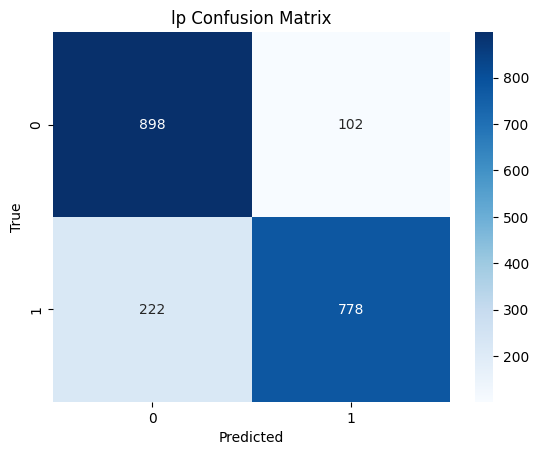


--- knn RESULTS ---
              precision    recall  f1-score   support

     Group 0       0.82      0.92      0.87      1000
     Group 1       0.91      0.80      0.85      1000

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



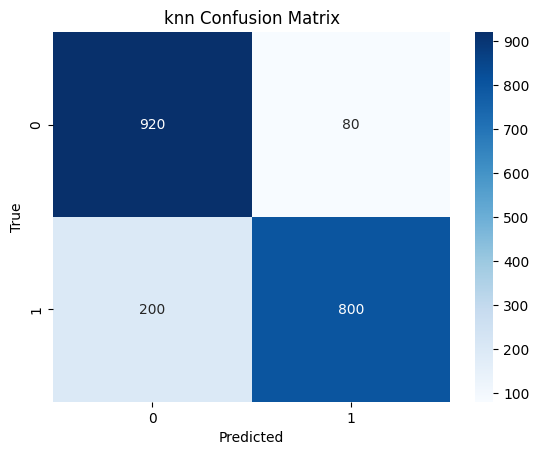


--- rf RESULTS ---
              precision    recall  f1-score   support

     Group 0       0.78      0.80      0.79      1000
     Group 1       0.79      0.78      0.79      1000

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



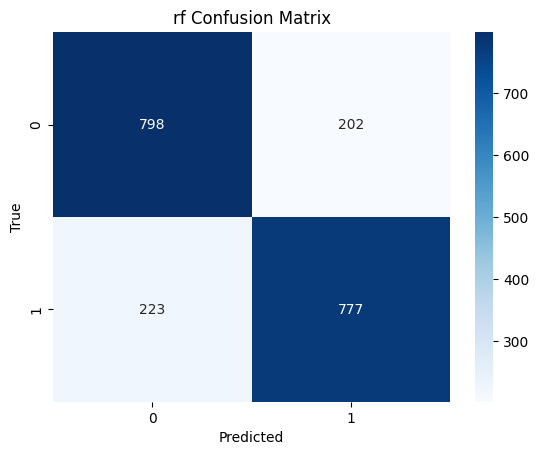


--- svm RESULTS ---
              precision    recall  f1-score   support

     Group 0       0.84      0.83      0.83      1000
     Group 1       0.83      0.84      0.84      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



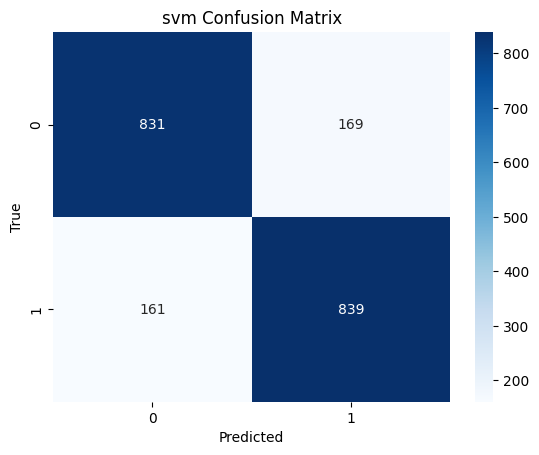

In [22]:
# 9. Evaluate both:
for name, model in best_models.items():
    print(f"\n--- {name} RESULTS ---")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Group 0','Group 1']))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0','1'], yticklabels=['0','1'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()